In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '8'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model, IsMovingTarget
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    
def vis_local_affinities(affinities, node=[250,400]):
    aff_node = affinities[:,:,node[0],node[1]]

    A = torch.zeros_like(affinities)
    A[:,:,node[0],node[1]] = aff_node
    K = aff_node.shape[-1] // 2
    aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,K:]], 1)    
    effects = fprop.compute_local_effects(torch.ones_like(affinities[:,:1]), aff_node)
    return effects
    

/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:2273: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance( exprs, collections.Sequence ):
/home/dbear/tenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:568: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## Now train on the larger dataset

In [4]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils
import dorsalventral.models.fire_propagation as fprop

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
#     root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
    dataset_names=['model_split_4'],    
#     dataset_names=['model_split_%d' % split for split in range(4)],
    split='training',
    filepattern="*",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=5,
    max_start_frame=5,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=True
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

1250
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
motion_path = '../checkpoints/35000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth'
# motion_path = '../checkpoints/motion-rnd0-tdw-bs8-large-fullplay-tr0-8.pth'

# mclass_teacher = load_model(
#                    motion_path,
#                    small=False, 
#                    cuda=True, 
#                    train=False)


mprop_student = load_model(None, 
                           model_class='prop', 
                           motion_ckpt=motion_path,
                   small=True, 
                   cuda=True, 
                   train=True, 
                   num_sample_points=4096,
                   affinity_nonlinearity='sigmoid',
                   motion_thresh=0.4,
                   positive_thresh=0.2,
                   negative_thresh=0.1,        
                   binarize_motion=True,
                   num_propagation_iters=10,
                   predict_every=1,
                   affinity_radius=7,
                   affinity_radius_inference=None,
                           corr_levels=4,
                   static_affinities=True)


IM = targets.IsMovingTarget(warp_radius=3, 
                            thresh=None, 
                            normalize_error=False, 
                            normalize_features=False).cuda()



raft_iters=2
loss_fn = nn.BCELoss(reduction='none')
target_thresh = 0.1
opt = torch.optim.Adam(mprop_student.parameters(), lr=0.0001)


def get_motion_target(img0, img1, img2, thresh=0.01):
    video = torch.stack([img0, img1, img2], 1).float() / 255.
    target = (IM(video)[:,0] > thresh).float()
    return target

def get_teacher_target(teacher, img0, img1, img2, thresh=0.25):
    motion_fwd = teacher(img1, img2, test_mode=False, iters=raft_iters)[-1]
#     motion_bck = teacher(img1, img0, test_mode=False, iters=raft_iters)[0]
    target = (torch.sigmoid(motion_fwd).detach() > thresh).float()
    return target

def train_step(data, model, optimizer, teacher=None, thresh=0.01, motion_scale=1.0, affinity_scale=1.0):
    
    optimizer.zero_grad()
    img1, img2, img0 = [d.cuda() for d in data[:3]]
    if teacher is None:
        target = get_motion_target(img0, img1, img2, thresh=thresh)
#         target = get_teacher_target(teacher, img0, img1, img2, thresh=thresh)
#     else:
#         target = get_teacher_target(teacher, img0, img1, img2, thresh=thresh)
    preds_list = model(img1, img2, test_mode=False, iters=raft_iters)
    
    if teacher is None:
        loss_list = [loss_fn(torch.sigmoid(pred), target).mean() for pred in preds_list]
        loss = motion_scale * (sum(loss_list) / len(loss_list))
    else:
#         loss_list = [loss_fn(pred.clamp(max=1.), target).mean() for pred in preds_list]
#         loss = motion_scale * loss_list[0] + affinity_scale * (sum(loss_list[1:]) / len(loss_list[1:]))
        loss_list = model.module.propagator.loss_list
        loss = motion_scale * loss_list[0] + affinity_scale * loss_list[1]
    loss.backward()
    optimizer.step()
    
    if teacher is not None:
        target = model.module.propagator.target
    
    return (preds_list, target, loss, loss_list)

def val_step(data, model, test_mode=True, motion_thresh=None, reverse=False):
    
    img1, img2, img0 = [d[None].cuda() for d in data[:3]]
    if reverse:
        _img2 = img2.clone()
        img1 = _img2
        img2 = img1
    target = get_motion_target(img0, img1, img2, thresh=target_thresh)
    if motion_thresh is not None:
        model.module.propagator.thresh = motion_thresh
    preds = model(img1, img2, test_mode=test_mode, iters=raft_iters)
    return (preds, target)
    
from dorsalventral.models.layer_utils import num_parameters
print("num params", num_parameters(mprop_student))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


motion model <All keys matched successfully>
static? True
num params 3707654


In [7]:
num_epochs = 100
num_steps = None
print_every = 5

rnd = 1

if rnd == 0:
    m_scale = 100.0
    a_scale = 0.
    teacher = None
    student = mclass_teacher
    target_thresh = 0.01
elif rnd == 1:
    m_scale = 1.
    a_scale = 1.
    teacher = mprop_student.module.motion_model
    student = mprop_student
    target_thresh = 0.1

batch_size = 1
trainloader = torch.utils.data.DataLoader(tdw_dataset, 
                                          batch_size=batch_size,
                                          shuffle=True,
                                          pin_memory=False,
                                          num_workers=4,
                                          drop_last=True)

running_losses = [0., 0., 0.]
for epoch in range(num_epochs):
    for step, data in enumerate(trainloader):
        if step == num_steps:
            break
        
        preds_list, target, loss, loss_list = train_step(data=data, model=student, optimizer=opt, teacher=teacher,
                                             thresh=target_thresh,
                                             motion_scale=m_scale, affinity_scale=a_scale)
        
        running_losses[0] += loss_list[0].item() / print_every
        running_losses[1] += loss_list[-1].item() / print_every
        running_losses[2] += loss.item() / print_every
        if (step % print_every) == 0:
            print("epoch %d / step %d ---- loss first %.3f ---- loss last %.3f ---- loss total %.3f" % 
                  (epoch, step, running_losses[0], running_losses[1], running_losses[2]))
            running_losses = [0., 0., 0.]
            
    if step == num_steps:
        break
        

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


epoch 0 / step 0 ---- loss first 0.192 ---- loss last 0.163 ---- loss total 0.355
epoch 1 / step 0 ---- loss first 0.116 ---- loss last 0.156 ---- loss total 0.272
epoch 2 / step 0 ---- loss first 0.123 ---- loss last 0.149 ---- loss total 0.273
epoch 3 / step 0 ---- loss first 0.103 ---- loss last 0.148 ---- loss total 0.251
epoch 4 / step 0 ---- loss first 0.086 ---- loss last 0.144 ---- loss total 0.230
epoch 5 / step 0 ---- loss first 0.079 ---- loss last 0.143 ---- loss total 0.222
epoch 6 / step 0 ---- loss first 0.082 ---- loss last 0.139 ---- loss total 0.221
epoch 7 / step 0 ---- loss first 0.081 ---- loss last 0.140 ---- loss total 0.222
epoch 8 / step 0 ---- loss first 0.064 ---- loss last 0.139 ---- loss total 0.203
epoch 9 / step 0 ---- loss first 0.055 ---- loss last 0.137 ---- loss total 0.192
epoch 10 / step 0 ---- loss first 0.087 ---- loss last 0.139 ---- loss total 0.226
epoch 11 / step 0 ---- loss first 0.064 ---- loss last 0.133 ---- loss total 0.197
epoch 12 / ste

epoch 99 / step 0 ---- loss first 0.030 ---- loss last 0.106 ---- loss total 0.136


In [8]:
# # save_path = '../checkpoints/prop_split4_100x_sigmoid_ep100.pth'
# # save_path = '../checkpoints/propmoving_split4_100x_sigmoid_ep100.pth'
# save_path = '../checkpoints/propstatic_split4_sigmoid_ep30.pth'
# save_path = '../checkpoints/propmoving_split4_sigmoid_ep75.pth'

save_path = '../checkpoints/cpropstatic_bias_split4exFull_sigmoid_ep30.pth'
# saved = torch.save(mprop_student.state_dict(), save_path)

# did_load = mprop_student.load_state_dict(torch.load(save_path), strict=False)
# print(did_load)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
ex = 0
tdw_dataset.get_backward_frame = True
mprop_student.train()
mprop_student.module.propagator.adj_thresh = 0.51
mprop_student.module.propagator.num_iters_inference = 10
mprop_student.module.propagator.I_inf = 4096

# mprop_student.module.propagator.r = 1
# mprop_student.module.propagator.k = 3
# mprop_student.module.propagator.K = 9
# mprop_student.module.propagator.p_thresh = 0.2
# mprop_student.module.propagator.n_thresh = 0.1

teacher_preds, target = val_step(tdw_dataset[ex], mprop_student.module.motion_model,
                                 test_mode=True, motion_thresh=None)
preds, target = val_step(tdw_dataset[ex], mprop_student, test_mode=True, motion_thresh=0.4)
len(preds)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


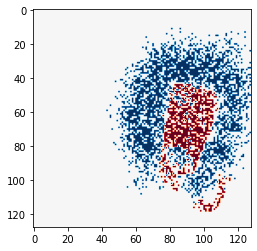

In [113]:
vis_utils.imshow(mprop_student.module.propagator.target, cmap='RdBu_r', vmin=-1, vmax=1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


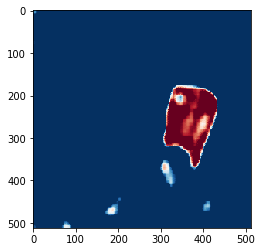

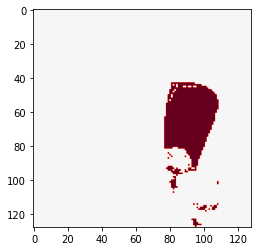

In [11]:
K = preds[0].shape[-3]
_K = K//2
vis_utils.imshow(preds[0][:,_K,None], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(preds[-1][-1], cmap='RdBu_r', vmin=-1, vmax=1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


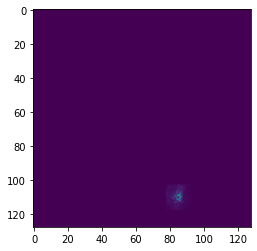

In [12]:

adj_local = torch.sigmoid(torch.cat([preds[0][:,:_K], preds[0][:,_K+1:]], 1))
adj_local = adj_local
plot = vis_local_affinities(transforms.Resize([128,128])(adj_local), node=[110,85])
vis_utils.imshow(plot, vmin=0, vmax=1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


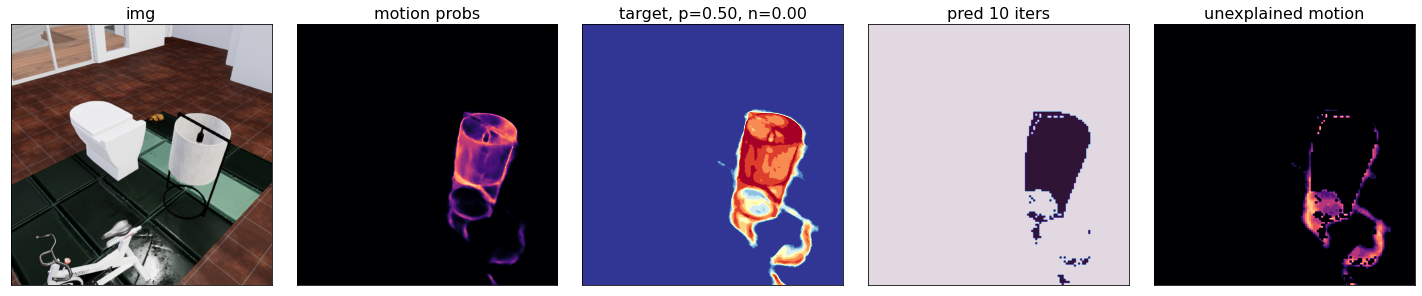

In [13]:
vmin, vmax = teacher_preds[-1].amin(), teacher_preds[-1].amax()
target = teacher_preds[-1]
# p_thresh, n_thresh = mprop_student.module.propagator.p_thresh, mprop_student.module.propagator.n_thresh
# p_thresh, n_thresh = 0.025, 0.01
# target_map = (torch.sigmoid(target) > p_thresh).int() - (torch.sigmoid(target) < n_thresh).int()

threshs = [0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]
target_map = torch.zeros_like(target)
for thresh in threshs:
    target_map += (torch.sigmoid(target) > thresh).float() * (1 / len(threshs))
    
unexplained_motion = target_map[...,::4,::4] - preds[1][-1]

fig, axes = plt.subplots(1,5, figsize=(20,4))
vis_utils.imshow(tdw_dataset[ex][0][None] / 255., axes[0])
vis_utils.imshow(torch.sigmoid(target), axes[1], cmap='magma', vmin=0, vmax=1)
vis_utils.imshow(target_map, axes[2], cmap='RdYlBu_r', vmin=0, vmax=1)
vis_utils.imshow(preds[1][-1], axes[3], cmap='twilight', vmin=0, vmax=2)
vis_utils.imshow(unexplained_motion, axes[4], cmap='magma', vmin=0, vmax=1)

# vis_utils.imshow(preds[-2], axes[3], cmap='inferno', vmin=0, vmax=preds[-2].amax().item())

titles = ['img', 'motion probs', 'target, p=%.2f, n=%.2f' % (threshs[-1], threshs[0]),
          'pred %d iters' % mprop_student.module.propagator.num_iters,
          'unexplained motion']
for i, ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=16)
plt.tight_layout()
plt.show()

In [25]:
tdw_dataset[ex][0].shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([3, 512, 512])

In [115]:
# cprop = fprop.ChainPropagation(num_iters=0, 
#                                local_radius=1,
#                                num_samples=20,
#                                confidence_thresh=1,
#                                num_initial_points=8,
#                                chain_multiplicity=2,
#                                downsample=4,
#                                bias_scales=[],
#                                bias_every=20,
#                                use_negative_log_probs=True).cuda()

M2S = fprop.MotionToStaticTarget().cuda()



/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [372]:
ex = 41
tdw_dataset.get_backward_frame = True
tdw_dataset.get_gt_flow = True
cprop.num_iters = 20
cprop.refractory = True
cprop.confidence_thresh = 3

teacher_preds, _ = val_step(tdw_dataset[ex], mprop_student.module.motion_model,
                                 test_mode=True, motion_thresh=None)
target = teacher_preds[-1]
print("target", target.shape)
p_sample, n_sample, conf_map = M2S(target)
print(p_sample.shape, n_sample.shape, conf_map.shape)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


target torch.Size([1, 1, 512, 512])
torch.Size([1, 16, 1, 128, 128]) torch.Size([1, 16, 1, 128, 128]) torch.Size([1, 1, 128, 128])


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


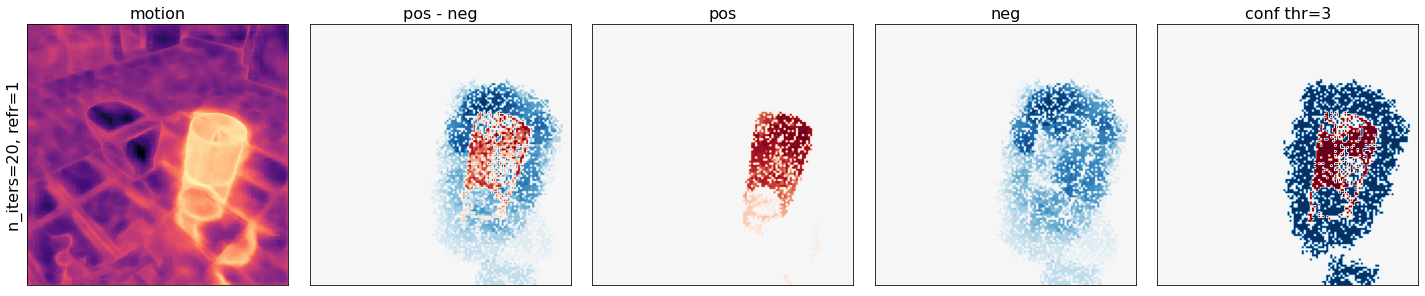

In [373]:
fig, axes = plt.subplots(1,5,figsize=(20,4))
vmax = max(cprop.S, 1)
vis_utils.imshow(target, axes[0], cmap='magma', vmin=target.amin(), vmax=target.amax())
vis_utils.imshow(p_sample.sum(1) - n_sample.sum(1), axes[1], cmap='RdBu_r', vmin=-vmax, vmax=vmax)
vis_utils.imshow(p_sample.mean(1), axes[2], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(n_sample.mean(1), axes[3], cmap='RdBu', vmin=-1, vmax=1)
vis_utils.imshow(conf_map, axes[4], cmap='RdBu_r', vmin=-1, vmax=1)

titles = ['motion', 'pos - neg', 'pos', 'neg', 'conf thr=%d' % cprop.confidence_thresh]
ylabel = "n_iters=%d, refr=%d" % (cprop.num_iters, cprop.refractory)
axes[0].set_ylabel(ylabel, fontsize=16)
for i,ax in enumerate(axes):
    ax.set_title(titles[i], fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


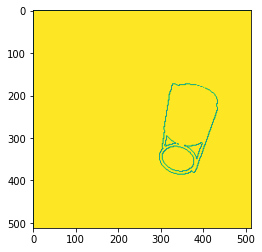

In [374]:
local_radius = 1
tdw_dataset.get_backward_frame = False
tdw_dataset.get_gt_flow = True
flow = tdw_dataset[ex][2]
gt_mask = flow[None].abs().sum(1, True) > 0
A_gt = fprop.get_local_neighbors(gt_mask, radius=local_radius, to_image=True)[:,0]
A_gt = (gt_mask == A_gt).float()
K = A_gt.shape[1]
_K = K//2
A_gt[:,_K] = gt_mask.float()
# A_gt = A_gt * gt_mask
vis_utils.imshow(A_gt[:,0,None])


In [417]:
# S2M = fprop.StaticToMotionTarget(num_initial_points=8, 
#                                  num_samples=16, 
#                                  num_iters=0,
#                                  use_prior=False,
#                                  refractory=False,
#                                  nonlinearity=nn.Identity(),
#                                  update_thresh=None).cuda()

S2M = fprop.StaticToMotionTarget(use_prior=True).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [424]:
# h = S2M(target, preds[0].detach())
S2M.num_iters = 50
# S2M.refractory = False
S2M.confidence_thresh = 8
S2M.confidence_weight = True
# h, m_targ = S2M(target, A_gt.cuda().detach())
h, m_targ = S2M(target, preds[0].detach())

print(h.amin(), h.amax())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


confidence-weighted affinities
tensor(0., device='cuda:0') tensor(1., device='cuda:0')


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


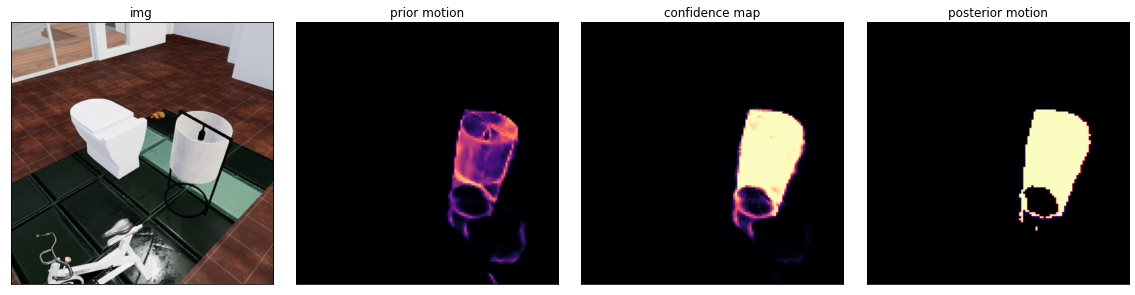

In [425]:
fig, axes = plt.subplots(1,4,figsize=(16,4))

vis_utils.imshow(tdw_dataset[ex][0][None] / 255., axes[0])
vis_utils.imshow(h, axes[2], cmap='magma', vmin=0, vmax=1)
vis_utils.imshow(m_targ.float(), axes[3], cmap='magma', vmin=0, vmax=1)
vis_utils.imshow(torch.sigmoid(transforms.Resize([128,128])(target)), axes[1], cmap='magma', vmin=0, vmax=1)

titles = ['img', 'prior motion', 'confidence map', 'posterior motion']
for i,ax in enumerate(axes):
    ax.set_title(titles[i])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AttributeError: 'ChainPropagation' object has no attribute 'n_flow'

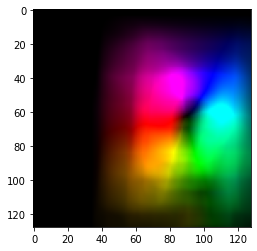

In [25]:
import dorsalventral.data.utils as data_utils

vis_utils.imshow(data_utils.FlowToRgb()(cprop.p_flow[:,0])) 
vis_utils.imshow(data_utils.FlowToRgb()(cprop.n_flow[:,0])) 

In [61]:
bias, flows = fprop.build_motion_affinity_target(
    target[:,None,...,::4,::4].sigmoid(),
    local_radius=5,
    pool_radii=[10,20,40],
    to_image=True
)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
bias.mean(-1).amax()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor(0.8304, device='cuda:0', grad_fn=<AmaxBackward>)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


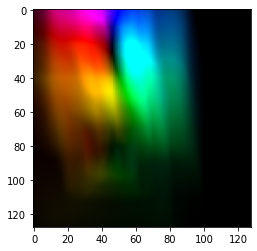

In [44]:
vis_utils.imshow(data_utils.FlowToRgb()(flows[:,0]))

# Does model learn to do better than its teacher?

In [17]:
from tqdm import tqdm
DEFAULT_CMAP = plt.cm.twilight
DEFAULT_ERRMAP_COLORS = {k:float(v)/DEFAULT_CMAP.N for k,v in {'tp': 250, 'tn': 0, 'fp': 420, 'fn': 80}.items()}

def plot_errormap(model, dataset, ex=None, iters=24, thresh=4, 
                  cmap=DEFAULT_CMAP,
                  colors=DEFAULT_ERRMAP_COLORS,
                  do_plot=True,
                  return_errormap=True,
                  return_images=False,
                  thingness=False
                 ):
    if ex is None:
        ex = np.random.randint(len(dataset))
        
    blob = dataset[ex]
    try:
        img1, img2, flow = blob[:3]
    except:
        img1, img2 = blob[:2]
        flow = torch.zeros_like(img1[:2])
    pred = model(img1[None].cuda(), img2[None].cuda(), iters=iters, test_mode=True)[-1]
    
    if thingness:
        _seg = lambda x, t: (x > t).cpu().numpy()[0,0]
    else:
        _seg = lambda x, t: (x.square().sum(-3).sqrt() > t).cpu().numpy()[0]
    pred_seg = _seg(pred, thresh)
    gt_seg = (flow.square().sum(-3).sqrt() > 0.5).cpu().numpy()
#     gt_seg = _seg(flow[None], 0.5)
    
    tp = pred_seg & gt_seg
    tn = ~pred_seg & ~gt_seg
    fp = pred_seg & ~gt_seg
    fn = ~pred_seg & gt_seg
    n = (pred_seg | gt_seg).sum() + 0.
    
    metrics = {
        'iou': tp.sum() / n,
        'precision': (tp.sum() + 0.) / (tp.sum() + fp.sum()),
        'recall': (tp.sum() + 0.) / (tp.sum() + fn.sum())
    }

    errmap = np.zeros(list(gt_seg.shape) + [3])
    errmap[pred_seg & gt_seg] = list(cmap(colors['tp']))[:3]
    errmap[~pred_seg & ~gt_seg] = list(cmap(colors['tn']))[:3]
    errmap[pred_seg & ~gt_seg] = list(cmap(colors['fp']))[:3]
    errmap[~pred_seg & gt_seg] = list(cmap(colors['fn']))[:3]
    
    if do_plot:
        plt.imshow(errmap)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    elif return_errormap:
        metrics['error_map'] = errmap
        
    if return_images:
        metrics.update({
            'image1': img1.permute(1, 2, 0).cpu().numpy() / 255.,
            'image2': img2.permute(1, 2, 0).cpu().numpy() / 255.,
            'pred': flow_viz.flow_to_image(tensor_to_arr(pred[0])) if not thingness else tensor_to_arr(torch.sigmoid(pred[0])),
            'gt': flow_viz.flow_to_image(tensor_to_arr(flow)) if not thingness else gt_seg
        })
    
    return metrics

def visualize_error_maps(model, dataset, examples=[0], iters=24, thresh=4, max_examples=5, thingness=False):
    
    def val_fn(ex):
        metrics = plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, 
                                do_plot=False, return_errormap=True, return_images=True, thingness=thingness)
        return metrics
    
    if examples is None:
        examples = [np.random.randint(len(dataset)) for _ in range(max_examples)]
    elif isinstance(examples, int):
        examples = [examples]
    else:
        examples = examples[:max_examples]
        
    titles = ['img1', 'img2', 'gt', 'pred @ %d iters' % iters, 'iou = ']
    n_rows = min(len(examples), max_examples)
    n_cols = len(titles)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    if n_rows == 1:
        axes = [axes]
    
    for row, ex in enumerate(examples):
        return_vals = val_fn(ex)
        ax = axes[row]
        ax[0].imshow(return_vals['image1'])
        ax[1].imshow(return_vals['image2'])
        ax[2].imshow(return_vals['gt'])
        ax[3].imshow(return_vals['pred'])
        ax[4].imshow(return_vals['error_map'])
        
        iou = return_vals['iou']
        ts = titles[:-1] + [titles[-1] + ("%.3f" % iou)]
        for col, title in enumerate(ts):
            if col == 4:
                ax[col].set_title(ts[col], fontsize=18, y=0.92)
            ax[col].set_xticks([])
            ax[col].set_yticks([])
        
    plt.tight_layout()
    plt.show()


def validate_examples(model, dataset, examples=[0], iters=24, thresh=4, thingness=False):
    
    def val_fn(ex):
        return plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, do_plot=False, 
                             return_errormap=False, thingness=thingness)
    
    if examples is None:
        examples = range(len(dataset))
    elif isinstance(examples, int):
        examples = [examples]
    
    metrics = {'iou': [], 'precision': [], 'recall': []}
    for ex in tqdm(examples):
        m = val_fn(ex)
        for k,v in m.items():
            metrics[k].append(v)
    return metrics

def agg_metrics(metrics):
    agg = {k:np.nanmean(np.array(v)) for k,v in metrics.items()}
    nans = {k+'_isnan':np.isnan(np.array(v)).mean() for k,v in metrics.items()}
    return (agg, nans)
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [426]:
tdw_dataset.is_test = True
tdw_dataset.get_backward_frame = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = range(5)
visualize_error_maps(mprop_student, tdw_dataset, examples=examples, thresh=0.5, thingness=True, iters=12)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[autoreload of dorsalventral.models.fire_propagation failed: Traceback (most recent call last):
  File "/home/dbear/tenv/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/dbear/tenv/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/dbear/tenv/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/dbear/tenv/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bo

NameError: name 'visualize_error_maps' is not defined

In [19]:
tdw_dataset.test_mode = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
mprop_student.module.propagator.p_thresh = 0.5

examples = range(10)
thresh = 0.5

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      ("model", tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mprop_student, tdw_dataset, examples=examples, thresh=thresh, iters=12, thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/10 [00:00<?, ?it/s]

evaluating model --- model --- val = False, 10 at thresh = 0.50


100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


({'iou': 0.5276661379505242,
  'precision': 0.6928235419744173,
  'recall': 0.6941701472510398},
 {'iou_isnan': 0.0, 'precision_isnan': 0.0, 'recall_isnan': 0.0})

In [24]:
tdw_dataset.test_mode = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
mprop_student.module.propagator.p_thresh = 0.5

examples = None
thresh = 0.5

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      ("model", tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mprop_student, tdw_dataset, examples=examples, thresh=thresh, iters=12, thingness=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- model --- val = True, 500 at thresh = 0.50


  0%|          | 1/500 [00:00<03:52,  2.14it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [05:33<00:00,  1.50it/s]


({'iou': 0.5793075615384295,
  'precision': 0.776164937604437,
  'recall': 0.7122651320314326},
 {'iou_isnan': 0.046, 'precision_isnan': 0.056, 'recall_isnan': 0.048})